## Global Imports

In [1]:
import pandas
import seaborn as sn
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
london = pandas.read_csv("/home/vivek/Documents/mydata/iimb/regression/regression_input_post_code_year_month_aggregate.csv")

/home/vivek/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (142) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [2]:
london.shape

(2189743, 152)

## Dummifying Month And Cluster Columns

In [2]:
london["month"] = london["year_month_new"].map(lambda x:int(str(x)[4:]))
monthDummies = pandas.get_dummies(london["month"],prefix="month"+"_")
london = pandas.concat([london,monthDummies],axis=1)
london.drop(["month"],axis=1,inplace=True)

clusterDummies = pandas.get_dummies(london["cluster"],prefix="cluster"+"_")
london = pandas.concat([london,clusterDummies],axis=1)
london.drop(["cluster"],axis=1,inplace=True)

In [3]:
londonPrice = london[london["year_month_new"]>=200901]  ## 199501 for full data
dropList = ["borough","ward","borough_code","latitude","longitude","yearBetween",\
            "YearMon","Year","Month","ward_code",'avg_co2_emission_in_kt', 'avg_population']
londonPrice = londonPrice.drop(dropList,axis=1)

train = londonPrice[londonPrice["year_month_new"]<201401]
test = londonPrice[londonPrice["year_month_new"]>=201401]
testCols = train.columns[3:]

##  Random Forest

In [103]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")
rf = RandomForestRegressor() 
param_grid = { 
    'n_estimators': [100],
    'criterion' : ["mse"],
    'max_features': ["sqrt"],
    'min_samples_split':[5],
    'min_samples_leaf':[5],
    'n_jobs':[4],
    'max_depth' : [None],
    'oob_score':[True],
    'verbose':[1]
}
grid_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv= 2)
X_train = train[testCols]
y = train["price"]
grid_rf.fit(X_train,y)

# Make predictions
predsTrain =grid_rf.predict(X= train[testCols])
predsTest = grid_rf.predict(X= test[testCols])

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   20.4s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.8s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    9.3s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   21.2s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.6s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.7s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   21.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   48.8s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: 

## Visuallizing Feature Importance

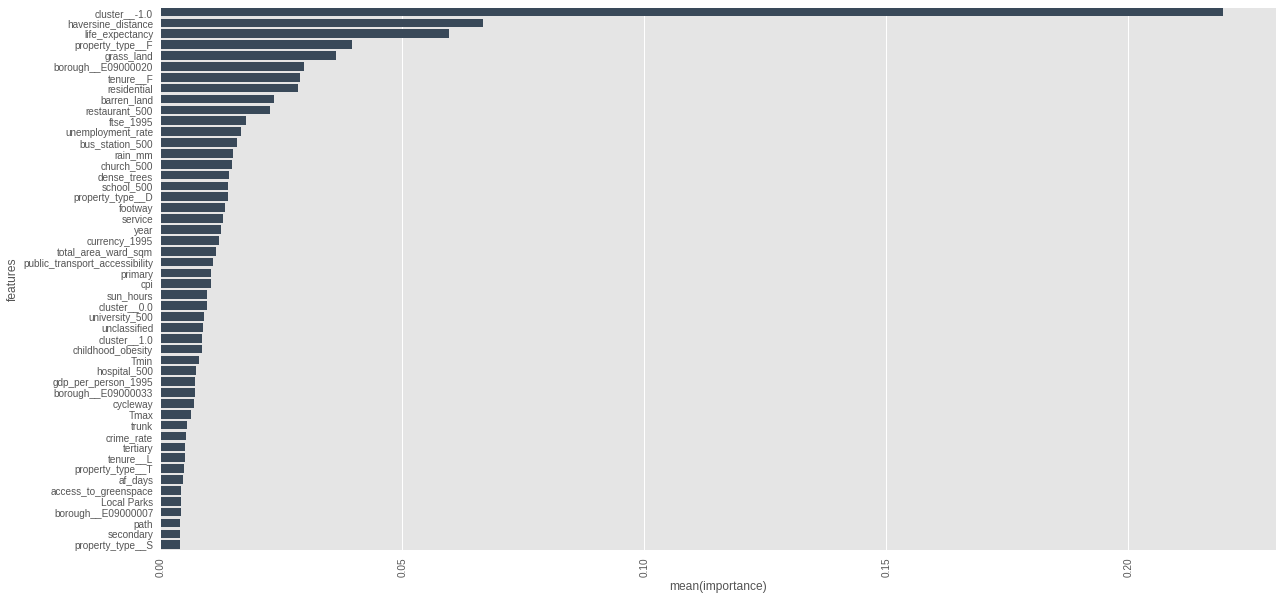

In [115]:
import seaborn as sn
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

rf = RandomForestRegressor() 
rf.fit(X_train,y)

featureImportance = list(rf.feature_importances_)
features = pandas.DataFrame()
features['features'] = testCols
features['importance'] = list(rf.feature_importances_)
features.sort_values(by=['importance'],ascending=False,inplace=True)
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
plt.xticks(rotation=90)
top = ["life_expectancy","restaurant_500","unemployment_rate","public_transport_accessibility"]
sn.barplot(data=features.head(50),x="importance",y="features",ax=ax,orient="h",color="#34495e")
#rf.feature_importances_

## Calculating Train And Test MAPE

In [104]:
print (grid_rf.best_params_)
trainResults = train
trainResults["Predicted"] = predsTrain
postalMeanTrain = pandas.DataFrame(trainResults.groupby(["post_code"])["price","Predicted"].mean()).reset_index()
postalMeanTrain["AP"] = abs(postalMeanTrain["price"]  -  postalMeanTrain["Predicted"])/postalMeanTrain["price"]
print("Train Mape: ",postalMeanTrain.AP.mean())

testResults = test
testResults["Predicted"] = predsTest
postalMeanTest = pandas.DataFrame(testResults.groupby(["post_code"])["price","Predicted"].mean()).reset_index()
postalMeanTest["AP"] = abs(postalMeanTest["price"]  -  postalMeanTest["Predicted"])/postalMeanTest["price"]
print("Test Mape: ",postalMeanTest.AP.mean())

print ("R2",grid_rf.score(X = X_train,y = y))

{'criterion': 'mse', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 100, 'n_jobs': 4, 'oob_score': True, 'verbose': 1}
Train Mape:  0.1325907513604325
Test Mape:  0.21078726567534947


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    3.7s finished


R2 0.749403942884


## Running Random Forest Model For Individual Clusters

In [ ]:
for clusNum in list(london["cluster"].unique()):
    print("cluster Num: ",clusNum)
    londonPrice = london[london["cluster"]==int(clusNum)]

    londonPrice = londonPrice[londonPrice["year_month_new"]>=200901]  #199501 for full data
    dropList = ["borough","ward","borough_code","latitude","longitude","yearBetween",\
                "YearMon","Year","Month","ward_code",'avg_co2_emission_in_kt', 'avg_population']
    londonPrice = londonPrice.drop(dropList,axis=1)

    train = londonPrice[londonPrice["year_month_new"]<201401]
    test = londonPrice[londonPrice["year_month_new"]>=201401]
    testCols = train.columns[3:]

    X_train = train[testCols]
    y = train["price"]

    # Initialize logistic regression model
    rf = RandomForestRegressor(n_estimators=500,max_features="sqrt",min_samples_split=5,\
                               min_samples_leaf=1,n_jobs=4,oob_score=True)
    # Train the model
    rf.fit(X = X_train,y = y)

    # Make predictions
    predsTrain =rf.predict(X= train[testCols])
    predsTest = rf.predict(X= test[testCols])


    trainResults = train
    trainResults["Predicted"] = predsTrain
    postalMeanTrain = pandas.DataFrame(trainResults.groupby(["post_code"])["price","Predicted"].mean()).reset_index()
    postalMeanTrain["AP"] = abs(postalMeanTrain["price"]  -  postalMeanTrain["Predicted"])/postalMeanTrain["price"]
    print("Train Mape: ",postalMeanTrain.AP.mean())

    testResults = test
    testResults["Predicted"] = predsTest
    postalMeanTest = pandas.DataFrame(testResults.groupby(["post_code"])["price","Predicted"].mean()).reset_index()
    postalMeanTest["AP"] = abs(postalMeanTest["price"]  -  postalMeanTest["Predicted"])/postalMeanTest["price"]
    print("Test Mape: ",postalMeanTest.AP.mean())

    print ("R2",rf.score(X = X_train,y = y))
    print("######## End Of Iteration ######\n")